In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
import pickle as pkl
import os
from pathlib import Path
from multiprocessing import Pool, cpu_count
import numpy as np
import pandas as pd
import zipfile
#import imageio
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision import *
from PIL import Image
from IPython.display import display
import zipfile
from glaucoma.helpers.glaucoma_helpers import *
from fastai.distributed import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
##### PLEASE SET AS REQUIRED########
WORKING_DIR = Path(os.getcwd())
DATA_DIR = WORKING_DIR / 'data'
META_DIR = DATA_DIR / 'metadata'
TRAIN_DIR = DATA_DIR / 'train'
UKBB_DIR = DATA_DIR 'retinal_images/UKBB'
CROP_DIR = DATA_DIR /'retinal_images/cropped_UKBB')
C_CLSA_DIR = DATA_DIR / 'retinal_images/cropped_CLSA')
GRADE_DIR = DATA_DIR / "gradable"
CLSA_DIR =DATA_DIR / 'retinal_images/CLSA')

In [49]:
def cal_radius(p1, p2):
    if isinstance(p1,str):
        p1 = tuple(map(int,p1.split(",")))
    if isinstance(p2,str):
        p2 = tuple(map(int,p2.split(",")))
    r2 = np.power(p2[0]- p1[0],2) + np.power(p2[1] - p1[1],2)
    return np.sqrt(r2)

### Unzipping files

In [10]:
zipped_files = parse_files(CLSA_DIR)
f_names = [os.path.basename(zf)[0:-4] for zf in zipped_files]

In [11]:
baseline = CLSA_DIR / f_names[0]/ '190225'
followup = CLSA_DIR / f_names[1]/'190225'

In [12]:
baseline_right = parse_files(baseline, 'right')
baseline_left = parse_files(baseline, 'left')
followup_right = parse_files(followup, 'right')
followup_left = parse_files(followup, 'left')

## CLSA Disk Diamater Inference

In [162]:
v2_graded = pkl.load(open(WORKING_DIR / 'graded_diameter_df.pkl','rb'))

In [14]:
src = ImageList.from_df(v2_graded, path = DATA_DIR / "diameter").split_by_rand_pct(seed=42).label_from_df(label_cls=FloatList)
tfms = get_transforms(max_lighting = 0.1,max_zoom = 1,max_warp = 0) # or tfms=None if none are needed
size= (800,1040) # size=(224,224) or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(num_workers=num_cpu).normalize(imagenet_stats)

In [15]:
learn_dd = cnn_learner(data,models.resnet34, pretrained = True)

In [16]:
model_name ='res34_2point_radius_unfreeze_only_heat_4'

In [ ]:
learn_dd.load(model_name)

In [33]:
learn_dd.data.batch_size = 32

In [36]:
learn_dd.model = torch.nn.DataParallel(learn_dd.model)

In [37]:
#load actual full UKBB data
crop_paths = [C_CLSA_DIR / 'baseline_left',
              C_CLSA_DIR / 'baseline_right',
              C_CLSA_DIR / 'followup_left',
              C_CLSA_DIR / 'followup_right'
             ]

In [38]:
crop_names = [os.path.basename(pth) for pth in crop_paths]

In [39]:
test_sets = [ImageList.from_folder(path) for path in crop_paths]

In [40]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [149]:
preds = learn_dd.get_preds()

In [168]:
preds_r = torch.tensor(standard_scaler.inverse_transform(preds[0]))

In [43]:
cdd_preds = {}
for i,test in enumerate(test_sets):
    learn_dd.data.add_test(test)
    pred = learn_dd.get_preds(DatasetType.Test)
    cdd_preds[os.path.basename(crop_paths[i])] = pred

In [ ]:
save_path = WORKING_DIR /"CLSA_dd_predictions_diameter_only_v1.pkl"
pkl.dump(cdd_preds,open(save_path,'wb'))
#vc_preds = pkl.load(open(save_path,'rb'))

## Data postprocess into df

In [160]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [161]:
standard_scaler = StandardScaler()

In [163]:
v2_graded['radius'] = standard_scaler.fit_transform(v2_graded[['radius']])

In [164]:
preds_r = torch.tensor(standard_scaler.inverse_transform(preds[0]))


In [53]:
crop_names = [os.path.basename(pth) for pth in crop_paths]
test_sets = [ImageList.from_folder(path) for path in crop_paths]
combined_test_set = {}
for i,ts in enumerate(test_sets):
    ts_list = list(ts.items)
    ts_list = [os.path.basename(x) for x in ts_list]
    combined_test_set[crop_names[i]] = ts_list
    

In [74]:
def build_df_diam_result(file_names, preds):
    file_names = np.asarray(file_names)
    file_names = file_names.reshape(len(file_names),1)
    #rescaled_preds = rescale_points(preds)
    # inverse the transformation
    preds = torch.tensor(standard_scaler.inverse_transform(preds))
    pred_arr = preds.numpy()
    full_arr = np.concatenate((file_names,pred_arr),axis=1)
    df = pd.DataFrame(full_arr)
    df.set_index(0,inplace = True)
    df = df.rename(columns = {0:'file',1:'radius'})
    df.index.rename("file_name",inplace =True)

    return df

In [75]:
keys = list(combined_test_set.keys())
df_dict = {}
for key in keys:
    print(key)
    df = build_df_diam_result(combined_test_set[key],cdd_preds[key][0])
    df_dict[key] = df

baseline_left
baseline_right
followup_left
followup_right


In [76]:
df_full = pd.concat([i for i in df_dict.values()])

In [94]:
df_full_baseline = pd.concat([df_dict['baseline_left'],df_dict['baseline_right']])
df_full_followup = pd.concat([df_dict['followup_left'],df_dict['followup_right']])

In [95]:
df_full_baseline['follow_up'] = 0

In [96]:
df_full_followup['follow_up'] = 1

In [99]:
df_full = pd.concat([df_full_baseline.reset_index(), df_full_followup.reset_index()])

In [104]:
CLSA_preds = df_full

## Comparing performance to human rater

In [184]:
CLSA_clin = pd.read_csv('/home/jovyan/glaucoma/set_xaa_alexhewitt.V2.VCDR',sep = '\t',header = None)

In [48]:
#calculate radius
CLSA_clin['radius'] 

,0,1,2,3
0,190225_QIMR_SMacGregor_1350403_left.jpg,"304,189:305,281",#,#
1,190225_QIMR_SMacGregor_1254895_left.jpg,"413,236:414,332",#,#
2,190225_QIMR_SMacGregor_1100420_left.jpg,"270,247:269,331",#,#
3,190225_QIMR_SMacGregor_1319579_left.jpg,"301,246:306,340",#,#
4,190225_QIMR_SMacGregor_1266754_left.jpg,"-1,-1:-1,-1",X,#
...,...,...,...,...
995,190225_QIMR_SMacGregor_1240822_left.jpg,"250,279:253,346",#,#
996,190225_QIMR_SMacGregor_1247572_left.jpg,"317,227:317,296",#,#
997,190225_QIMR_SMacGregor_1277542_left.jpg,"312,224:315,297",#,#
998,190225_QIMR_SMacGregor_1152851_left.jpg,"275,264:275,344",#,#


In [186]:
CLSA_clin[["coord1","coord2"]] = CLSA_clin[1].str.split(":",expand = True).loc[:,0:1]

In [188]:
CLSA_clin['radius'] = CLSA_clin.apply(lambda x:cal_radius(x.coord1,x.coord2),axis =1)

In [236]:
graded_CLSA = CLSA_clin[(CLSA_clin['radius'] > 1) & (CLSA_clin['radius'] < 200)]

In [249]:
old_model_CLSA =pd.read_csv(WORKING_DIR / 'inference'/'CLSA_disk_full_inference_v1.csv')

In [252]:
old_model_CLSA =old_model_CLSA[old_model_CLSA['follow_up'] ==1]

In [238]:
# pull out relevant preds:
files = graded_CLSA[0]
ratings  =graded_CLSA['radius']

In [267]:
CLSA_preds.to_csv("CLSA_disk_full_inference_v2.csv")

In [239]:
used_preds = CLSA_preds[CLSA_preds['file_name'].isin(files)]
used_preds = used_preds[used_preds['follow_up'] == 1]
used_preds['radius']=used_preds['radius'].astype(float)

In [ ]:
for i in graded_CLSA[0]:
    graded_CLSA.loc[graded_CLSA[0] == i,'predicted_old'] = old_model_CLSA.loc[old_model_CLSA['file_name'] == i,'radius'].astype('float').item()
    

In [273]:
X = np.array(graded_CLSA['radius'])
Y = np.array(graded_CLSA['predicted'])

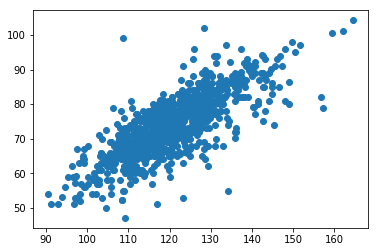

In [274]:
plt.scatter(Y,X)
#plt.ylim([40,110])

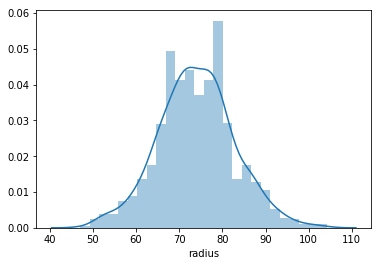

In [276]:
sns.distplot(graded_CLSA['radius'])

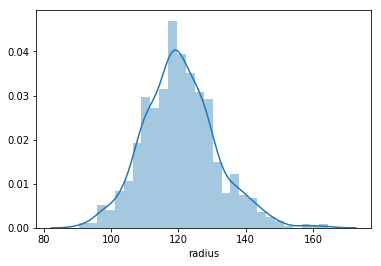

In [277]:
sns.distplot(used_preds['radius'])

In [278]:
correlation_matrix = np.corrcoef(X, Y)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

In [279]:
correlation_xy

0.7855049239507709

# UKBB inference

In [269]:
#load actual full UKBB data
crop_paths = [CROP_DIR /'crop_image_21015_0_0_png',
         CROP_DIR /'crop_image_21015_0_1_png',
         CROP_DIR /'crop_image_21015_1_0_png',
         CROP_DIR /'crop_image_21016_0_0_png',
         CROP_DIR /'crop_image_21016_0_1_png',
         CROP_DIR /'crop_image_21016_1_0_png'
        ]

In [284]:
crop_names = [os.path.basename(pth) for pth in crop_paths]

In [285]:
test_sets = [ImageList.from_folder(path) for path in crop_paths]

In [272]:
uk_preds = {}
for i,test in enumerate(test_sets):
    learn_dd.data.add_test(test)
    pred = learn_dd.get_preds(DatasetType.Test)
    uk_preds[os.path.basename(crop_paths[i])] = pred

In [280]:
save_path = WORKING_DIR /"UKBB_dd_predictions_diameter_only_v1.pkl"
pkl.dump(cdd_preds,open(save_path,'wb'))
#vc_preds = pkl.load(open(save_path,'rb'))

## Processing DF

In [286]:
crop_names = [os.path.basename(pth) for pth in crop_paths]
test_sets = [ImageList.from_folder(path) for path in crop_paths]
combined_test_set = {}
for i,ts in enumerate(test_sets):
    ts_list = list(ts.items)
    ts_list = [os.path.basename(x) for x in ts_list]
    combined_test_set[crop_names[i]] = ts_list
    

In [287]:
def build_df_diam_result(file_names, preds):
    file_names = np.asarray(file_names)
    file_names = file_names.reshape(len(file_names),1)
    #rescaled_preds = rescale_points(preds)
    # inverse the transformation
    preds = torch.tensor(standard_scaler.inverse_transform(preds))
    pred_arr = preds.numpy()
    full_arr = np.concatenate((file_names,pred_arr),axis=1)
    df = pd.DataFrame(full_arr)
    df.set_index(0,inplace = True)
    df = df.rename(columns = {0:'file',1:'radius'})
    df.index.rename("file_name",inplace =True)

    return df

In [288]:
keys = list(combined_test_set.keys())
df_dict = {}
for key in keys:
    print(key)
    df = build_df_diam_result(combined_test_set[key],uk_preds[key][0])
    df_dict[key] = df

crop_image_21015_0_0_png
crop_image_21015_0_1_png
crop_image_21015_1_0_png
crop_image_21016_0_0_png
crop_image_21016_0_1_png
crop_image_21016_1_0_png


In [289]:
df_full = pd.concat([i for i in df_dict.values()])

In [293]:
df_full.to_csv(WORKING_DIR / 'UKBB_disk_full_inference_v2.csv')